# Pondering the Problem of Fitting a Model

## Dividing between training, test and validation

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

def load_california_housing_data():
    dataset = fetch_california_housing()
    X = pd.DataFrame(data=dataset.data, 
                     columns=dataset.feature_names)
    y = pd.Series(data=dataset.target, name="target")
    return X, y

X, y = load_california_housing_data()

print(X.shape, y.shape)

(20640, 8) (20640,)


In [2]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_jobs=-1)
knn_model.fit(X, y)

r2 = knn_model.score(X, y)

print(f"R-squared value: {r2:.2f}")

R-squared value: 0.47


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (16512, 8)
Testing set shape: (4128, 8)


In [4]:
from sklearn.metrics import mean_squared_error

knn_model.fit(X_train, y_train)

preds_train = knn_model.predict(X_train)
preds_test = knn_model.predict(X_test)

train_mse = mean_squared_error(y_true=y_train, y_pred=preds_train)
print(f"Train mean squared error: {train_mse:.5f}")

Train mean squared error: 0.73442


In [5]:
test_mse = mean_squared_error(y_true=y_test, 
                              y_pred=preds_test)
print(f"Test mean squared error: {test_mse:.5f}")

Test mean squared error: 1.11733


# Cross-validating

## Using cross-validation on k folds

In [6]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

cv = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(knn_model, X, y, cv=cv,
    scoring='neg_mean_squared_error', n_jobs=-1)

mean_mse = np.mean(np.abs(scores))
std_mse = np.std(scores)

print(f"cv mean squared error: {mean_mse:.5f} std: {std_mse:.5f}")

cv mean squared error: 1.10818 std: 0.02739


## Sampling stratifications for complex data

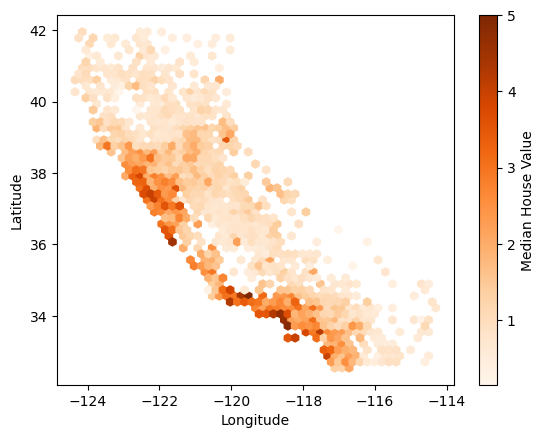

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

plt.hexbin(X.Longitude, X.Latitude, C=y, gridsize=50, 
           cmap='Oranges')
cb = plt.colorbar()
cb.set_label('Median House Value')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.show()


see: https://www.kaggle.com/competitions/playground-series-s3e1/discussion/376210
https://www.kaggle.com/code/dmitryuarov/ps-s3e1-coordinates-key-to-victory

In [8]:
from sklearn.cluster import KMeans

coordinates = X[["Latitude","Longitude"]]

clustering = KMeans(n_clusters=20, n_init=10, 
                    random_state=0)
clustering.fit(coordinates)

area = clustering.predict(coordinates)

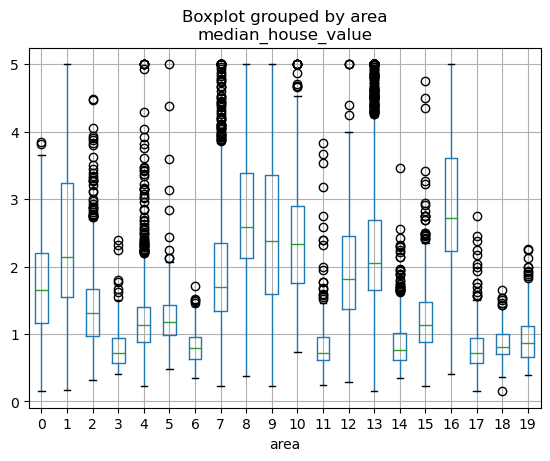

In [9]:
df_area = pd.DataFrame({"area": area, "median_house_value": y})
df_area.boxplot("median_house_value", by="area");

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

skf = StratifiedKFold(n_splits=10, shuffle=True, 
                      random_state=0)
scores = list()

for train_index, test_index in skf.split(X, area):
    X_train, X_test = X.iloc[train_index], \
        X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    scores.append(mean_squared_error(y_true=y_test,
                                     y_pred=y_pred))

print('%i folds cv mean squared error: %.5f std: %.5f' % 
      (len(scores),np.mean(np.abs(scores)),
       np.std(scores)))

10 folds cv mean squared error: 1.09899 std: 0.04505


# Selecting Variables Like a Pro

In [11]:
df_area = pd.get_dummies(area, prefix="area")
df_X = pd.concat([X, df_area], axis=1)

## Selecting on univariate measures

In [12]:
from sklearn.feature_selection import r_regression

correlations = r_regression(df_X, y)
for n, s in zip(df_X.columns, correlations):
    print(f"F-score: {s:+2.3f} for feature {n}")

F-score: +0.688 for feature MedInc
F-score: +0.106 for feature HouseAge
F-score: +0.152 for feature AveRooms
F-score: -0.047 for feature AveBedrms
F-score: -0.025 for feature Population
F-score: -0.024 for feature AveOccup
F-score: -0.144 for feature Latitude
F-score: -0.046 for feature Longitude
F-score: -0.047 for feature area_0
F-score: +0.188 for feature area_1
F-score: -0.129 for feature area_2
F-score: -0.155 for feature area_3
F-score: -0.167 for feature area_4
F-score: -0.065 for feature area_5
F-score: -0.111 for feature area_6
F-score: -0.025 for feature area_7
F-score: +0.101 for feature area_8
F-score: +0.158 for feature area_9
F-score: +0.045 for feature area_10
F-score: -0.108 for feature area_11
F-score: -0.011 for feature area_12
F-score: +0.087 for feature area_13
F-score: -0.180 for feature area_14
F-score: -0.159 for feature area_15
F-score: +0.217 for feature area_16
F-score: -0.146 for feature area_17
F-score: -0.094 for feature area_18
F-score: -0.137 for feature 

## Employing forward and backward selection

In [13]:
%%time
from sklearn.feature_selection \
    import SequentialFeatureSelector

selector = SequentialFeatureSelector(
    estimator=knn_model,
    direction='forward',
    cv=3,
    scoring='neg_mean_squared_error',
    n_features_to_select=14
)

selector.fit(df_X, y)
feature_mask = selector.support_
selected = [feature for feature, 
            support in zip(df_X.columns, 
                           feature_mask) if support]
print(f"Selected features: {selected}")

Selected features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'area_0', 'area_3', 'area_4', 'area_5', 'area_8', 'area_10', 'area_14', 'area_17', 'area_19']
CPU times: total: 48 s
Wall time: 1min 45s


# Pumping up your hyper-parameters

## Implementing a grid search

In [14]:
knn_model = KNeighborsRegressor(n_jobs=1)

In [15]:
param_grid = {'n_neighbors': [1, 3, 5, 7, 10, 25, 50, 100],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan',
                         'cosine']}

In [16]:
from sklearn.model_selection import cross_val_score

score_metric = 'neg_mean_squared_error'
scores = cross_val_score(
    knn_model,
    X=df_X.loc[:, feature_mask],
    y=y,
    cv=10,
    scoring=score_metric,
    n_jobs=-1
)

baseline_score = np.mean(np.abs(scores))
print(f"Baseline with default parameters: {baseline_score:.3f}")

Baseline with default parameters: 0.538


In [17]:
%%time
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring=score_metric,
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    cv=10
)

search.fit(df_X.loc[:, feature_mask], y)

C:\Users\John\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the train scores are non-finite: [ 0.00000000e+00  0.00000000e+00 -2.46120279e-01  0.00000000e+00
 -3.08398354e-01  0.00000000e+00 -3.39110395e-01  0.00000000e+00
 -3.64953427e-01  0.00000000e+00 -4.15728226e-01  0.00000000e+00
 -4.46200275e-01  0.00000000e+00 -4.80452551e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.45320785e-01  0.00000000e+00
 -3.05044242e-01  0.00000000e+00 -3.34751601e-01  0.00000000e+00
 -3.60495664e-01  0.00000000e+00 -4.10149430e-01  0.00000000e+00
 -4.45031987e-01  0.00000000e+00 -4.84498230e-01  0.00000000e+00
             nan -1.79902758e-34 -2.44616609e-01 -1.45692155e-21
 -3.00812506e-01 -1.96540343e-21 -3.27108945e-01 -2.42138786e-21
 -3.50582641e-01 -3.02392894e-21 -3.92173463e-01 -5.81192895e-21
 -4.17868341e-01 -9.91016115e-21 -4.45438810e-01 -1.72908282e-20]
  warnings.warn(


CPU times: total: 5.58 s
Wall time: 1h 11min 29s


GridSearchCV(cv=10, estimator=KNeighborsRegressor(n_jobs=1), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'cosine'],
                         'n_neighbors': [1, 3, 5, 7, 10, 25, 50, 100],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [18]:
print(f"Best parameters: {search.best_params_}")
print(f"CV mean squared error of best parameters: {abs(search.best_score_):.3f}")

Best parameters: {'metric': 'cosine', 'n_neighbors': 50, 'weights': 'distance'}
CV mean squared error of best parameters: 0.481


In [19]:
print(search.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_metric', 'param_n_neighbors', 'param_weights', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


In [20]:
from sklearn.model_selection import validation_curve

tuned_model = KNeighborsRegressor(**search.best_params_, 
                                  n_jobs=-1)

train, test = validation_curve(tuned_model,
    df_X.loc[:, feature_mask], y,
    param_name='n_neighbors', param_range=range(10, 101, 10), 
    cv=3, scoring=score_metric, n_jobs=-1)

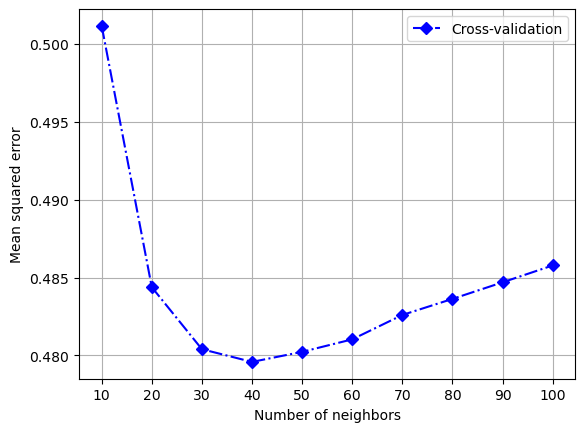

In [21]:
import matplotlib.pyplot as plt

mean_test = abs(np.mean(test, axis=1))

x_ticks_labels = range(10, 101, 10)
x_ticks_values = range(0, len(x_ticks_labels))
plt.plot(x_ticks_values, mean_test, 'bD-.', 
         label='Cross-validation')
plt.grid()
plt.xlabel('Number of neighbors')
plt.xticks(x_ticks_values, x_ticks_labels)
plt.ylabel('Mean squared error')
plt.legend(loc='upper right', numpoints=1)
plt.show()

## Trying a randomized search

In [22]:
%%time
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

search = HalvingGridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring=score_metric,
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    cv=10,
    factor=2,
    max_resources='auto',
    aggressive_elimination=True,
    random_state=42
)

search.fit(df_X.loc[:, feature_mask], y)
print(f"Best parameters: {search.best_params_}")
best_score = abs(search.best_score_)
print(f"CV mean squared error of best parameters: "
      f"{best_score:.3f}")

Best parameters: {'metric': 'cosine', 'n_neighbors': 50, 'weights': 'distance'}
CV mean squared error of best parameters: 0.481
CPU times: total: 4.19 s
Wall time: 9min 46s


In [23]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_neighbors': range(1, 100),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'cosine']
             }

random_search = RandomizedSearchCV(
    estimator=knn_model, 
    param_distributions=param_grid, 
    n_iter=10,
    cv=10,
    scoring=score_metric,
    refit=True, 
    random_state=0,
    n_jobs=-1
)

random_search.fit(df_X.loc[:, feature_mask], y)
print(f"Best parameters: {random_search.best_params_}")
best_score = abs(random_search.best_score_)
print(f"CV mean squared error of best parameters: "
      f"{best_score:.3f}")

Best parameters: {'weights': 'distance', 'n_neighbors': 37, 'metric': 'cosine'}
CV mean squared error of best parameters: 0.480
CPU times: total: 922 ms
Wall time: 14.8 s
